# Modeli strojnog učenja


[*Jupyter*](https://jupyter.org/) bilježnica Davora Penzara u sklopu diplomskog rada ($ 2020 $. godine na [*Matematičkom odsjeku*](https://www.math.pmf.unizg.hr/) [*Prirodoslovno-matematičkog fakulteta*](https://www.pmf.unizg.hr/) [*Sveučilišta u Zagrebu*](http://www.unizg.hr/)).

U ovoj su bilježnici predstavljeni modeli strojnog učenja kao programska rješenja opisana u diplosmkom radu.


## Sadržaj <a class="anchor" id="table-of-contents"></a>


1.  [Priprema okruženja](#environment-preparation)
2.  [Linearna regresija](#linear-regression)
    1.  [Polinom stupnja $ 4 $](#lr-polynomial-4)
    2.  [Polinom stupnja $ 5 $](#lr-polynomial-5)
    3.  [Zaključak](#lr-conclusion)
3.  [Neuronska mreža](#neural-network)
    1.  [Zaključak](#nn-conclusion)
4.  [Konvolucijska neuronska mreža](#convolutional-neural-network)
    1.  [Zaključak](#cnn-conclusion)
5.  [Bibliografija](#bibliography)


## Priprema okruženja <a class="anchor" id="environment-preparation"></a>


Učitavanje potrebnih paketa&hellip;


In [0]:
# Import IPython.
from IPython import *
from IPython.display import *


In [0]:
# Import standard library.
import copy
import enum
import gc
import math
import numbers
import six
import sys
import time


In [0]:
# Import SciPy packages.
import matplotlib as mpl
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sympy as sym
from mpl_toolkits.mplot3d import Axes3D


(izbriši `#` s početka sljedeće linije za učitavanje [*TensorFlow*](https://www.tensorflow.org/) verzije 2.x)


In [0]:
#%tensorflow_version 2.x


In [4]:
# Import TensorFlow.
import tensorflow as tf


In [0]:
# Import SciKit Learn.
import sklearn as sk
import sklearn.linear_model as lm


In [6]:
# Import Keras.
import keras
import keras.activations as ka
import keras.backend as K
import keras.callbacks as kc
import keras.layers as kl
import keras.losses as ke
import keras.models as km
import keras.optimizers as ko


Using TensorFlow backend.


Za spajanje na [*Google Drive*](https://drive.google.com/) učitaj i sljedeće pakete (ako se [*Jupyter*](https://jupyter.org/) bilježnica izvršava lokalno, sljedeća čelija nije potrebna, ali se sadržaj kasnijih čelija mora mijenjati).


In [0]:
# Import Google Colab.
import google
import google.colab as colab


Namještavanje okruženja&hellip;


In [0]:
%matplotlib inline


In [0]:
#sym.init_printing()


In [0]:
plt.style.use('default')


Spajanje na [*Google Drive*](https://drive.google.com/)&hellip;


In [10]:
colab.drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Navigiranje u direktorij na [*Google Drive*u](https://drive.google.com/)&hellip;


In [11]:
%cd '/content/drive/My Drive/destination_folder'


/content/drive/My Drive/destination_folder


(izbriši `#` s početka sljedeće linije za kloniranje [*GitHub*](https://github.com/) repozitorija s potrebnim materijalima)


In [0]:
#!git clone https://github.com/DavorPenzar/diplomski.git


Navigiranje u direktorij kloniranog [*GitHub*](https://github.com/) repozitorija&hellip;


In [12]:
%cd diplomski


/content/drive/My Drive/destination_folder/diplomski


Dohvaćanje najnovije verzije [*GitHub*](https://github.com/) repozitorija&hellip;


In [0]:
!git fetch


In [14]:
!git pull origin


Already up to date.


Navigiranje u poddirektorij s k&ocirc;dovima&hellip;


In [15]:
%cd code


/content/drive/My Drive/destination_folder/diplomski/code


Učitavanje vlastitih [*Python*](https://www.python.org/) skripti&hellip;


In [0]:
from usefulness import *
from MST_CNN import *


Definiranje dodatnih klasa i funkcija za olakšani kasniji rad&hellip;


Definiranje enumeracijske klase za označavanje podskupova podataka (koordinate točaka, numeričke značajke i ciljna varijabla) i funkcije za učitavanje podataka&hellip;


In [0]:
class DataSubSet (enum.IntEnum):
    """
    Enumeration notation of dataset subsets.

    Elementary subsets and its notation values are:
        coordinates     =  1    = 0b00001
        characteristics =  2    = 0b00010
        descritpions    =  4    = 0b00100
        singular_values =  8    = 0b01000
        eigenvalues     = 16    = 0b10000

    Combined subsets can be denoted using elementary subset notation and the
    binary or operator, such as
        >>> DataSubSet.descriptions | DataSubSet.singular_values | DataSubSet.eigenvalues
        28
    or by using the exact value (28 in the case above).  Splitting a combined
    subset on elementary subsets can be done using the binary and operator, such
    as
        >>> bool(28 & DataSubSet.singular_values)
        True
        >>> bool(28 & DataSubSet.coordinates)
        False

    Caution: the "descriptions" dataset is actually the sorted descriptions
    dataset.

    """

    # Define the elementary subsets' notations.
    coordinates     = 0b00001
    characteristics = 0b00010
    descriptions    = 0b00100
    singular_values = 0b01000
    eigenvalues     = 0b10000

    # Define the order of the subsets' notations.
    __order__ = (
        'coordinates characteristics descriptions singular_values eigenvalues'
    )


In [0]:
def load_df (
    superset,
    which,
    subset = (DataSubSet.coordinates | DataSubSet.eigenvalues)
):
    """
    Load a dataset as a Pandas dataframe.

    Parameters
    ==========
    superset : {'numerical', 'imagination'}
        Dataset collection from which to load the dataset.

    which : {'train', 'validation', 'test'}
        Which dataset to load.

    subset : int in range [1, 31], optional
        Enumeration notation of the subset to load (see the documentation for
        `DataSubSet`) (default is 17, i. e. coordinates and eigenvalues).

    Returns
    =======
    DataFrame
        Dataframe of the desired dataset.

    """

    # Initialise the list of dataframes to an empty list.
    dfs = list()

    # Add the desired dataframes to the list `dfs`.
    if (subset & DataSubSet.coordinates):
        dfs.append(
            read_tsv(
                "data/{sup:s}/{at:s}/coordinates.tsv".format(
                    sup = superset,
                    at = which
                ),
                names = ['x_0', 'y_0', 'x_1', 'y_1', 'x_2', 'y_2']
            )
        )
    if (subset & DataSubSet.characteristics):
        dfs.append(
            read_tsv(
                "data/{sup:s}/{at:s}/characteristics.tsv".format(
                    sup = superset,
                    at = which
                ),
                names = ['x_char', 'y_char']
            )
        )
    if (subset & DataSubSet.descriptions):
        dfs.append(
            read_tsv(
                "data/{sup:s}/{at:s}/sorted_descriptions.tsv".format(
                    sup = superset,
                    at = which
                ),
                names = ['a', 'c', 'b', 'alpha', 'gamma', 'beta']
            )
        )
    if (subset & DataSubSet.singular_values):
        dfs.append(
            read_tsv(
                "data/{sup:s}/{at:s}/singular_values.tsv".format(
                    sup = superset,
                    at = which
                ),
                names = [
                    'sv_edge_0',
                    'sv_edge_1',
                    'sv_edge_2',
                    'sv_angle_0',
                    'sv_angle_1',
                    'sv_angle_2'
                ]
            )
        )
    if (subset & DataSubSet.eigenvalues):
        dfs.append(
            read_tsv(
                "data/{sup:s}/{at:s}/eigenvalues.tsv".format(
                    sup = superset,
                    at = which
                ),
                names = ['l_0']
            )
        )

    # Concatenate the dataframes in the list `dfs` and return them.
    return (
        pd.concat(dfs, axis = 1) if dfs
            else pd.DataFrame(np.zeros((0, 0), dtype = float, order = 'C'))
    )


Definiranje pomoćne klase za učitavanje i spremanje skupova podataka&hellip;

S klasom `DataSet` moguće je učitati sve podatke (za trening, validaciju i testiranje) odjednom i olakšana je manipulacija podatcima. Na primjer, moguće je sljedeće:

```Python
num = DataSet('numerical')  # Učitaj sve podatke iz 'data/numerical'.
num.train.describe()        # Dohvati deskriptivu učitanih podataka za treniranje.
```


In [0]:
class DataSet (object):
    """
    Class for representing dataset collections.

    Parameters
    ==========
    name : {'numerical', 'imagination'}
        Dataset collection (see documentation for parameter `superset` at
        `load_df`).

    subset : int in range [1, 31], optional
        Enumeration notation of the subsets to load (see the documentation for
        parameter `subset` at `load_df`) (default is 31, i. e. all subsets).

    """

    def __new__ (cls, name = str(), subset = 0):
        # Create a new instance.
        ds = super(DataSet, cls).__new__(cls)

        # Initialise all attributes as `None`.
        ds._name = None
        ds._train = None
        ds._validation = None
        ds._test = None

        # Return the created instance.
        return ds

    def __init__ (self, name, subset = 31):
        # Initialise the instance of the super class.
        super(DataSet, self).__init__()

        # Set the instance's attributes.
        self._name = copy.deepcopy(str(name))
        self._train = load_df(self._name, 'train', subset)
        self._validation = load_df(self._name, 'validation', subset)
        self._test = load_df(self._name, 'test', subset)

    def __copy__ (self):
        """
        Return `copy.copy(self)`.

        """

        # Create a new instance.
        ds = DataSet.__new__(DataSet)

        # Copy the attributes from `self`.
        ds._name = self._name
        ds._train = self._train
        ds._validation = self._validation
        ds._test = self._test

        # Return the created copy.
        return ds

    def __deepcopy__ (self, memo = None, _nil = list()):
        """
        Return `copy.deepcopy(self, memo, _nil)`.

        """

        # Create a new instance.
        ds = DataSet.__new__(DataSet)

        # Copy the attributes from `self`.
        ds._name = copy.deepcopy(self._name, memo, _nil)
        ds._train = self._train.copy(deep = True)
        ds._validation = self._validation.copy(deep = True)
        ds._test = self._test.copy(deep = True)

        # Return the created copy.
        return ds

    def join_validation_test (self):
        """
        Move the validation set to the testing set joining the two with ignoring
        the indices.

        Caution: the validation data will be cleared.

        """

        # Join the validation and the testing data into the testing data.
        self._test = pd.concat(
            (self._validation, self._test),
            axis = 0,
            ignore_index = True
        )

        # Clear the validation data.
        if self._validation.shape[0]:
            self._validation = self._validation.iloc[0:0].copy(deep = True)
        else:
            self._validation = self._validation.copy(deep = True)

    def __repr__ (self):
        """
        Return `repr(self)`.

        """

        return "<DataSet of {name:s}>".format(name = self._name)

    def __iter__ (self):
        """
        Iterate over the training, validation and testing sets (in that order).

        """

        yield self._train
        yield self._validation
        yield self._test

    @property
    def name (self):
        """
        Name of the dataset collection (`str`).

        """

        return copy.deepcopy(self._name)

    @property
    def train (self):
        """
        Trainig set (`pandas.DataFrame`).

        """

        return self._train

    @property
    def validation (self):
        """
        Validation set (`pandas.DataFrame`).

        """

        return self._validation

    @property
    def test (self):
        """
        Testing set (`pandas.DataFrame`).

        """

        return self._test


Definiranje vlastite aktivacijske funkcije `ReLU`$ {} \circ x \mapsto x^{{- 1}} $&hellip;


In [0]:
def relu_mult_inv (x):
    """
    Return `relu(x ** -1)`.

    """

    return K.relu(K.pow(x, -1))


Učitavanje postavki grafova (granice prikaza, oznake vrijednosti&hellip;)&hellip;


In [0]:
from limits_ticks import *


Učitavanje $ 5 \, \% $-thih kvantila ciljne varijable&hellip;


In [0]:
l_0_quant = np.load('data/arrays/l_quantiles.npy')


## Linearna regresija <a class="anchor" id="linear-regression"></a>


Definiranje pomoćnih funkcija za računanje greške predviđanja na [*NumPy*](https://numpy.org/) poljima&hellip;


In [0]:
def np_mean_squared_error (y_true, y_predicted):
    """
    Get the mean squared error of NumPy arrays.

    """

    return np.mean((y_true - y_predicted).ravel() ** 2)


In [0]:
def np_mean_absolute_error (y_true, y_predicted):
    """
    Get the mean absolute error of NumPy arrays.

    """

    return np.mean(np.abs((y_true - y_predicted).ravel()))


In [0]:
def np_mean_absolute_percentage_error (y_true, y_predicted):
    """
    Get the mean absolute percentage error of NumPy arrays.

    """

    return 100.0 * np.mean(np.abs(((y_true - y_predicted) / y_true).ravel()))


In [0]:
def np_errors (y_true, y_predicted):
    """
    Get the MSE, MAE and MAPE of NumPy arrays.

    """

    return {
        'MSE' : np_mean_squared_error(y_true, y_predicted),
        'MAE' : np_mean_absolute_error(y_true, y_predicted),
        'MAPE' : np_mean_absolute_percentage_error(y_true, y_predicted)
    }


Definiranje pomoćne funkcije za konstruiranje članova polinoma&hellip;


In [0]:
def polynomial_terms_creator (n):
    """
    Construct a function for generating variables of a polynomial of degree n in
    two variables.

    """

    # Construct the function.
    def polynomial_terms (x, y):
        # Initialise the list of terms to `None`s.
        terms = list(None for i in six.moves.range((n + 2) * (n + 1) // 2 - 1))
        try:
            del i
        except (NameError, UnboundLocalError):
            pass

        # Initialise the index to 0.
        i = 0

        # Construct the terms.
        for k in six.moves.range(1, n + 1):
            # Construct the term `x ** k` and increment the index `i`.
            terms[i] = (x ** k if k > 1 else x)
            i += 1

            # Construct all terms `x ** (k - r) * y ** r` for `r` in
            # [2 .. k - 1] and increment the index `i` after creating each term.
            for r in six.moves.range(1, k):
                terms[i] = (
                    (x ** (k - r) if k - r > 1 else x) *
                    (y ** r if r > 1 else y)
                )
                i += 1

            # Construct the term `y ** k`.
            terms[i] = (y ** k if k > 1 else y)
            i += 1
        try:
            del k
        except (NameError, UnboundLocalError):
            pass

        # Free the memory.
        del i

        # Return the constructed list of terms.
        return terms

    # Return the constructed function.
    return polynomial_terms


Konstruiranje pomoćnih varijabli za konstrukciju notacije članova polinoma.


In [0]:
x = sym.Symbol('x', real = True)
y = sym.Symbol('y', real = True)


Učitavanje skupa podataka&hellip;


In [0]:
num = DataSet('numerical', DataSubSet.coordinates | DataSubSet.eigenvalues)
num.join_validation_test()


### Polinom stupnja $ 4 $ <a class="anchor" id="lr-polynomial-4"></a>


Definiranje stupnja polinoma kao varijable `n`&hellip;


In [0]:
n = 4


Konstruiranje funkcije za generiranje članova polinoma&hellip;


In [0]:
polynomial_terms = polynomial_terms_creator(n)


Konstruiranje indeksa stupaca s članovima polinoma&hellip;


In [0]:
polynomial_index = pd.Index(
    list(str(term) for term in polynomial_terms(x, y)),
    dtype = str,
    copy = True
)
try:
    del term
except (NameError, UnboundLocalError):
    pass


Računanje članova polinoma&hellip;


In [0]:
for df in iter(num):
    for term_ind, term in zip(
        polynomial_index,
        polynomial_terms(df.x_1, df.y_1)
    ):
        df[term_ind] = term
    try:
        del term_ind
    except (NameError, UnboundLocalError):
        pass
    try:
        del term
    except (NameError, UnboundLocalError):
        pass
try:
    del df
except (NameError, UnboundLocalError):
    pass


**Konstruiranje modela linearne regresije kao instance klase `scikit.linear_model.LinearRegressin` za računanje koeficijenata polinoma&hellip;**


In [0]:
polynomial_4 = lm.LinearRegression()


**Treniranje modela&hellip;**


In [35]:
polynomial_4.fit(num.train[polynomial_index], num.train.l_0 ** -1)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

**Dohvaćanje koeficijenata polinoma&hellip;**


Slobodni član


In [36]:
polynomial_4.intercept_


-2.010154572221201e-05

Vezani koeficijenti


In [37]:
polynomial_4.coef_


array([ 1.86432232e-05,  1.05705665e-03, -1.39305244e-03,  2.52679066e-03,
        7.17536930e-02,  3.16331976e-03,  1.15877955e-03, -1.00715309e-02,
       -8.35010891e-02, -6.66294235e-04, -1.07584242e-02, -1.04812081e-02,
        9.23778068e-03,  3.28964982e-02])

**Predviđanje na testnom skupu podataka&hellip;**


In [0]:
l_0_inv_predicted = polynomial_4.predict(num.test[polynomial_index])


**Računanje greške na testnom skupu podataka&hellip;**


Na cijelom skupu&hellip;


In [39]:
np_errors(num.test.l_0, l_0_inv_predicted ** -1)


{'MAE': 7.270954420736734,
 'MAPE': 0.4967814283016139,
 'MSE': 1333.7506801430188}

Po $ 5 \, \% $-tnim kvantilima&hellip;


In [40]:
# Display errors on 5 % quantiles.
for i in six.moves.range(int(l_0_quant.size) - 1):
    # Extract the indices of the `i`-th quantile.
    I = (num.test.l_0 >= l_0_quant[i]) & (num.test.l_0 < l_0_quant[i + 1])

    # Display the error on the `i`-th quantile.
    print(
        "{ind:2d}: {low:7.2f} -- {high:7.2f}".format(
            ind = i + 1,
            low = l_0_quant[i],
            high = l_0_quant[i + 1]
        )
    )
    display(np_errors(num.test.loc[I, 'l_0'], l_0_inv_predicted[I] ** -1))
    print(str())

    # Free the memory.
    del I
try:
    del i
except (NameError, UnboundLocalError):
    pass


 1:   52.72 --   55.41


{'MAE': 0.026451793542631098,
 'MAPE': 0.048674496753512646,
 'MSE': 0.001082211218709}


 2:   55.41 --   58.46


{'MAE': 0.02594822696330964,
 'MAPE': 0.04539915011543259,
 'MSE': 0.0010020938147126347}


 3:   58.46 --   62.06


{'MAE': 0.034680830910445756,
 'MAPE': 0.057522161457241164,
 'MSE': 0.0016432601718666658}


 4:   62.06 --   66.20


{'MAE': 0.027204282930385116,
 'MAPE': 0.04252787218986498,
 'MSE': 0.001159578683749254}


 5:   66.20 --   71.01


{'MAE': 0.03496360693380909,
 'MAPE': 0.05078414749629178,
 'MSE': 0.0021032597277842024}


 6:   71.01 --   76.74


{'MAE': 0.04978760779069682,
 'MAPE': 0.06729432270727428,
 'MSE': 0.0038791783377381704}


 7:   76.74 --   83.51


{'MAE': 0.050007414310019614,
 'MAPE': 0.062384101770255704,
 'MSE': 0.004508557457363603}


 8:   83.51 --   91.80


{'MAE': 0.059100053655418,
 'MAPE': 0.06735962960167498,
 'MSE': 0.005504347403186905}


 9:   91.80 --  102.00


{'MAE': 0.07795781777670598,
 'MAPE': 0.08007748440679108,
 'MSE': 0.010866834206272213}


10:  102.00 --  114.76


{'MAE': 0.14489867945095822,
 'MAPE': 0.13381181595455327,
 'MSE': 0.03587071138929071}


11:  114.76 --  130.69


{'MAE': 0.19669878116760678,
 'MAPE': 0.15888534105741328,
 'MSE': 0.06507965864485546}


12:  130.69 --  152.54


{'MAE': 0.5379140069290749,
 'MAPE': 0.37935527929891705,
 'MSE': 0.3959144618985815}


13:  152.54 --  181.99


{'MAE': 0.8495229847098695,
 'MAPE': 0.5089853973265922,
 'MSE': 1.0203010639936945}


14:  181.99 --  221.86


{'MAE': 1.0074068460345156,
 'MAPE': 0.5008007363918375,
 'MSE': 2.17384146245197}


15:  221.86 --  282.86


{'MAE': 1.2565723611324526,
 'MAPE': 0.4969241782998773,
 'MSE': 2.401710193235148}


16:  282.86 --  381.22


{'MAE': 3.4302899659188704,
 'MAPE': 1.0266879051241296,
 'MSE': 17.205317114065327}


17:  381.22 --  541.76


{'MAE': 4.451004283214469,
 'MAPE': 0.9958515139898054,
 'MSE': 30.257574733479597}


18:  541.76 --  861.51


{'MAE': 4.825557704596434,
 'MAPE': 0.7094174726155069,
 'MSE': 36.388353414264266}


19:  861.51 -- 1714.84


{'MAE': 13.190746180100584,
 'MAPE': 1.0326358178174904,
 'MSE': 432.9104206961501}


20: 1714.84 -- 5942.29


{'MAE': 115.1423749866664, 'MAPE': 3.470249741657818, 'MSE': 26152.12747002978}

**Grafički prikaz točnosti predviđanja&hellip;**


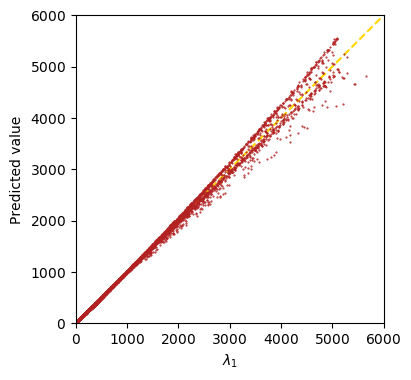

In [41]:
# Create a figure.
fig = plt.figure(num = 'Prediction error', figsize = (4.0, 4.0))

# Create a subplot.
ax = fig.add_subplot(1, 1, 1)

# Set the aspect of the subplot to equal.
ax.set_aspect('equal')

# Plot the identity line.
ax.plot(
    np.linspace(l_0_quant[0], l_0_quant[-1]),
    np.linspace(l_0_quant[0], l_0_quant[-1]),
    color = 'gold',
    linestyle = '--',
    marker = 'None'
)

# Plot lambda_0 prediction over true lambda_0.
ax.plot(
    num.test.l_0,
    l_0_inv_predicted ** -1,
    color = 'firebrick',
    linestyle = 'None',
    marker = '.',
    ms = 1
)

# Set axis labels.
ax.set_xlabel("$ \\lambda_{1} $")
ax.set_ylabel('Predicted value')

# Set ticks.
ax.set_xticks(ticks['l_0'])
ax.set_yticks(ticks['l_0'])

# Set tick labels.
ax.set_xticklabels(ticklabels['l_0'])
ax.set_yticklabels(ticklabels['l_0'])

# Set axis limits.
ax.set_xlim(lim['l_0'])
ax.set_ylim(lim['l_0'])

# Save the figure.
fig.savefig('polynomial_4_prediction.pdf', bbox_inches = 'tight')

# Show the plot.
plt.show()


In [0]:
# Free the memory.
del fig
del ax


In [0]:
# Free the memory.
num.train.drop(polynomial_index, axis = 1, inplace = True)
del n
del polynomial_terms
del polynomial_index
del l_0_inv_predicted


### Polinom stupnja $ 5 $ <a class="anchor" id="lr-polynomial-5"></a>


Definiranje stupnja polinoma kao varijable `n`&hellip;


In [0]:
n = 5


Konstruiranje funkcije za generiranje članova polinoma&hellip;


In [0]:
polynomial_terms = polynomial_terms_creator(n)


Konstruiranje indeksa stupaca s članovima polinoma&hellip;


In [0]:
polynomial_index = pd.Index(
    list(str(term) for term in polynomial_terms(x, y)),
    dtype = str,
    copy = True
)
try:
    del term
except (NameError, UnboundLocalError):
    pass


Računanje članova polinoma&hellip;


In [0]:
for df in iter(num):
    for term_ind, term in zip(
        polynomial_index,
        polynomial_terms(df.x_1, df.y_1)
    ):
        df[term_ind] = term
    try:
        del term_ind
    except (NameError, UnboundLocalError):
        pass
    try:
        del term
    except (NameError, UnboundLocalError):
        pass
try:
    del df
except (NameError, UnboundLocalError):
    pass


**Konstruiranje modela linearne regresije kao instance klase `scikit.linear_model.LinearRegressin` za računanje koeficijenata polinoma&hellip;**


In [0]:
polynomial_5 = lm.LinearRegression()


**Treniranje modela&hellip;**


In [49]:
polynomial_5.fit(num.train[polynomial_index], num.train.l_0 ** -1)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

**Dohvaćanje koeficijenata polinoma&hellip;**


Slobodni član


In [50]:
polynomial_5.intercept_


-1.5863418179834152e-05

Vezani koeficijenti


In [51]:
polynomial_5.coef_


array([-1.00479834e-03,  1.27109239e-03,  1.51762635e-02,  3.27179136e-05,
        7.10673999e-02, -6.79083968e-02, -5.06740147e-02,  2.72541611e-02,
       -8.50918423e-02,  1.25538959e-01,  1.67171185e-01, -2.93886758e-03,
       -6.26566121e-02,  3.87161319e-02, -8.41070953e-02, -1.45508207e-01,
       -9.54913415e-02,  4.34678097e-02,  3.77676598e-02, -3.94042121e-03])

**Predviđanje na testnom skupu podataka&hellip;**


In [0]:
l_0_inv_predicted = polynomial_5.predict(num.test[polynomial_index])


**Računanje greške na testnom skupu podataka&hellip;**


Na cijelom skupu&hellip;


In [53]:
np_errors(num.test.l_0, l_0_inv_predicted ** -1)


{'MAE': 5.982228812599356,
 'MAPE': 0.45509733922892315,
 'MSE': 875.4654835573284}

Po $ 5 \, \% $-tnim kvantilima&hellip;


In [54]:
# Display errors on 5 % quantiles.
for i in six.moves.range(int(l_0_quant.size) - 1):
    # Extract the indices of the `i`-th quantile.
    I = (num.test.l_0 >= l_0_quant[i]) & (num.test.l_0 < l_0_quant[i + 1])

    # Display the error on the `i`-th quantile.
    print(
        "{ind:2d}: {low:7.2f} -- {high:7.2f}".format(
            ind = i + 1,
            low = l_0_quant[i],
            high = l_0_quant[i + 1]
        )
    )
    display(np_errors(num.test.loc[I, 'l_0'], l_0_inv_predicted[I] ** -1))
    print(str())

    # Free the memory.
    del I
try:
    del i
except (NameError, UnboundLocalError):
    pass


 1:   52.72 --   55.41


{'MAE': 0.017093920805952685,
 'MAPE': 0.031445528286058094,
 'MSE': 0.0005232116667473562}


 2:   55.41 --   58.46


{'MAE': 0.021345775200398674,
 'MAPE': 0.037331245309344424,
 'MSE': 0.0006269011117754322}


 3:   58.46 --   62.06


{'MAE': 0.026851096740880764,
 'MAPE': 0.0445483912069637,
 'MSE': 0.0010533375695055748}


 4:   62.06 --   66.20


{'MAE': 0.024372831422800913,
 'MAPE': 0.03800596071078502,
 'MSE': 0.0010370778961626519}


 5:   66.20 --   71.01


{'MAE': 0.034371636609864885,
 'MAPE': 0.04998855048439441,
 'MSE': 0.0018235853445664832}


 6:   71.01 --   76.74


{'MAE': 0.04335032372816614,
 'MAPE': 0.05861419864718092,
 'MSE': 0.0028756192326833577}


 7:   76.74 --   83.51


{'MAE': 0.04112676631900292,
 'MAPE': 0.051192948737865236,
 'MSE': 0.003241179139990584}


 8:   83.51 --   91.80


{'MAE': 0.06544042672451159,
 'MAPE': 0.0744615525446239,
 'MSE': 0.006415748046420108}


 9:   91.80 --  102.00


{'MAE': 0.0851898084667885,
 'MAPE': 0.08750803975360893,
 'MSE': 0.01252823336653638}


10:  102.00 --  114.76


{'MAE': 0.14594177198425204,
 'MAPE': 0.13485785024479063,
 'MSE': 0.03218986709312481}


11:  114.76 --  130.69


{'MAE': 0.18110807240396343,
 'MAPE': 0.14654393609152172,
 'MSE': 0.05270483778850116}


12:  130.69 --  152.54


{'MAE': 0.5195351589407585,
 'MAPE': 0.3659032179015255,
 'MSE': 0.38844518051725535}


13:  152.54 --  181.99


{'MAE': 0.8403736007450963,
 'MAPE': 0.5030661673284149,
 'MSE': 1.001122282779056}


14:  181.99 --  221.86


{'MAE': 1.0126579720375388,
 'MAPE': 0.5047629054693487,
 'MSE': 2.2035293038271306}


15:  221.86 --  282.86


{'MAE': 1.1912451356666762,
 'MAPE': 0.4711774263558432,
 'MSE': 2.2485283507589306}


16:  282.86 --  381.22


{'MAE': 3.2532160281639118,
 'MAPE': 0.9751677529259981,
 'MSE': 15.34854893899512}


17:  381.22 --  541.76


{'MAE': 3.661763086059891,
 'MAPE': 0.8210839886640873,
 'MSE': 21.392404241579825}


18:  541.76 --  861.51


{'MAE': 5.657629392470384,
 'MAPE': 0.8146636679754923,
 'MSE': 47.86257895826848}


19:  861.51 -- 1714.84


{'MAE': 16.208380971577405,
 'MAPE': 1.3081310410803455,
 'MSE': 428.91574020116315}


20: 1714.84 -- 5942.29


{'MAE': 86.6135824759189, 'MAPE': 2.583492414860269, 'MSE': 16989.83375409042}

**Grafički prikaz točnosti predviđanja&hellip;**


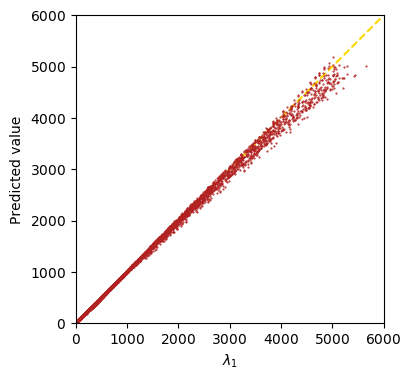

In [55]:
# Create a figure.
fig = plt.figure(num = 'Prediction error', figsize = (4.0, 4.0))

# Create a subplot.
ax = fig.add_subplot(1, 1, 1)

# Set the aspect of the subplot to equal.
ax.set_aspect('equal')

# Plot the identity line.
ax.plot(
    np.linspace(l_0_quant[0], l_0_quant[-1]),
    np.linspace(l_0_quant[0], l_0_quant[-1]),
    color = 'gold',
    linestyle = '--',
    marker = 'None'
)

# Plot lambda_0 prediction over true lambda_0.
ax.plot(
    num.test.l_0,
    l_0_inv_predicted ** -1,
    color = 'firebrick',
    linestyle = 'None',
    marker = '.',
    ms = 1
)

# Set axis labels.
ax.set_xlabel("$ \\lambda_{1} $")
ax.set_ylabel('Predicted value')

# Set ticks.
ax.set_xticks(ticks['l_0'])
ax.set_yticks(ticks['l_0'])

# Set tick labels.
ax.set_xticklabels(ticklabels['l_0'])
ax.set_yticklabels(ticklabels['l_0'])

# Set axis limits.
ax.set_xlim(lim['l_0'])
ax.set_ylim(lim['l_0'])

# Save the figure.
fig.savefig('polynomial_5_prediction.pdf', bbox_inches = 'tight')

# Show the plot.
plt.show()


In [0]:
# Free the memory.
del fig
del ax


In [0]:
# Free the memory.
num.train.drop(polynomial_index, axis = 1, inplace = True)
del n
del polynomial_terms
del polynomial_index
del l_0_inv_predicted


### Zaključak <a class="anchor" id="lr-conclusion"></a>


Razvijeni modeli `polynomial_4` i `polynomial_5` luče solidne rezultate iako se srednja kvadratna greška od $ 36.5206 $ odnosno $ 29.5883 $ čini visokom. No, kako vrijednost koju modeli predviđaju ima veliki raspon, apsolutno velike greške na *visokim* vrijednostima mogu biti relativno male, ali pritom jako utječu na srednju kvadratnu grešku cijelog modela. Stoga srednja apsolutna postotna greška od $ 0.4968 \, \% $ odnosno $ 0.45510 \, \% $ daje bolji uvid u točnost ovih modela. Osim toga, relativne greške po kvantilima ciljne varijable također ukazuju na solidnu točnost ovih modela; doduše, točnost modela (i apsolutna i relativna) opada s porastom ciljne varijable.


In [0]:
# Free the memory.
del num
del x
del y
del polynomial_4
del polynomial_5


In [0]:
# Free the memory.
del np_mean_squared_error
del np_mean_absolute_error
del np_mean_absolute_percentage_error
del np_errors


## Neuronska mreža <a class="anchor" id="neural-network"></a>


Učitavanje podataka&hellip;


In [0]:
num = DataSet(
    'numerical',
    DataSubSet.descriptions |
        DataSubSet.singular_values |
        DataSubSet.eigenvalues
)


Stupac *a* je konstantan (najdulja stranica svim trokutima iznosi $ 1 $), stupac *sv_angle_0* (najveća singularna vrijednost vanjskih kutova) gotovo pa je konstantan (poprima tri vrijednosti u intervalu širine $ 2 \cdot 10^{{- 8}} $), stupac *sv_edge_2* (treća najveća singularna vrijednost duljina stranica) (gotovo) jednak je stupcu *sv_edge_1* (druga najveća singularna vrijednost duljina stranica), i stupac *sv_angle_2* (treća najveća singularna vrijednost vanjskih kutova) (gotovo) jednak je stupcu *sv_angle_1* (druga najveća singularna vrijednost vanjskih kutova); stoga, brisanje nepotrebnih stupaca&hellip;


In [0]:
for df in iter(num):
    df.drop(
        ['a', 'sv_edge_2', 'sv_angle_0', 'sv_angle_2'],
        axis = 1,
        inplace = True
    )
try:
    del df
except (NameError, UnboundLocalError):
    pass


Konstruiranje indeksa stupaca sa značajkama&hellip;


In [0]:
features_index = pd.Index(
    num.train.columns[num.train.columns != 'l_0'],
    dtype = str,
    copy = True
)


Normalizacija skupova podataka u obliku $ X \leftarrow \frac{X - \overline{X}}{\sigma \left( X \right)} $, gdje je $ \overline{X} $ prosjek i $ \sigma \left( X \right) $ standardna devijacija uzorka značajki na skupu podataka za treniranje&hellip;


In [0]:
# Compute the mean and the standard deviation of features on the training set.
X_mean = num.train[features_index].mean(axis = 0).values.ravel()
X_std = num.train[features_index].std(axis = 0, ddof = 1).values.ravel()
X_std[np.isclose(1.0, 1.0 + X_std)] = 1.0

# Normalise all sets by the computed mean and the computed standard deviation.
for df in iter(num):
    df[features_index] = (df[features_index] - X_mean) / X_std
try:
    del df
except (NameError, UnboundLocalError):
    pass

# Free the memory.
del X_mean
del X_std


**Konstruiranje modela neuronske mreže kao instance klase `keras.models.Sequential`&hellip;**


In [0]:
model = km.Sequential(name = 'NN')


**Dodavanje slojeva u neuronsku mrežu&hellip;**


Neuronska mreža ima arhitekturu:

*   ulaz: $ 8 $ značajki,
*   $ 1 $. skriveni sloj ($ 1 $. prednji skriveni sloj): $ 16 $ neurona, aktivacija: `ReLU`,
*   $ 2 $. skriveni sloj ($ 2 $. prednji skriveni sloj): $ 32 $ neurona, aktivacija: `ReLU`,
*   $ 3 $. skriveni sloj ($ 3 $. prednji skriveni sloj): $ 64 $ neurona, aktivacija: `ReLU`,
*   $ 4 $. skriveni sloj (srednji sloj): $ 4 $ neurona, aktivacija: `ReLU`$ {} \circ x \mapsto x^{{- 1}} $,
*   $ 5 $. skriveni sloj (stražnji skriveni sloj): $ 256 $ neurona, aktivacija: `ReLU`,
*   izlaz: $ 1 $ vrijednost.


In [65]:
# Add the first fully-connected hidden layer.
model.add(
    kl.Dense(
        input_dim = 8,
        units = 16,
        activation = 'relu',
        name = 'front_fully_connected_1'
    )
)

# Add the second fully-connected hidden layer.
model.add(
    kl.Dense(
        units = 32,
        activation = 'relu',
        name = 'front_fully_connected_2'
    )
)

# Add the third fully-connected hidden layer.
model.add(
    kl.Dense(
        units = 64,
        activation = 'relu',
        name = 'front_fully_connected_3'
    )
)

# Add the middle fully-connected hidden layer.
model.add(
    kl.Dense(
        units = 4,
        activation = relu_mult_inv,
        name = 'middle_fully_connected'
    )
)

# Add the back fully-connected hidden layer.
model.add(
    kl.Dense(
        units = 256,
        activation = 'relu',
        name = 'back_fully_connected_1'
    )
)

# Add the output layer.
model.add(
    kl.Dense(
        units = 1,
        activation = 'linear',
        name = 'output'
    )
)


**Izgradnja neuronske mreže&hellip;**


(optimizacija je `Adadelta` s inicijalnom brzinom učenja od $ 1.0 $)


In [66]:
model.compile(
    optimizer = ko.Adadelta(lr = 1.0),
    loss = 'mean_squared_error',
    metrics = ['mean_absolute_error', 'mean_absolute_percentage_error']
)


**Treniranje neuronske mreže&hellip;**


In [67]:
# Train the model.
history = model.fit(
    x = num.train[features_index],
    y = num.train.l_0,
    batch_size = 2048,
    epochs = 2000,
    validation_data = (num.validation[features_index], num.validation.l_0),
    shuffle = True,
    verbose = 1,
    callbacks = [
        kc.TerminateOnNaN(),
        kc.ModelCheckpoint(
            'models/neural_network.h5',
            monitor = 'val_loss',
            save_best_only = True,
            mode = 'min',
            period = 1
        )
    ]
)

# Save the history as a CSV table.
pd.DataFrame(history.history, index = history.epoch).to_csv(
    'models/neural_network_history.csv',
    sep = ',',
    float_format = "%.8f",
    header = True,
    index = True
)

# Delete the model and history.
del model
del history

# Load the model with the best weights.
model = km.load_model(
    'models/neural_network.h5',
    custom_objects = {'relu_mult_inv' : relu_mult_inv}
)

# Load the history.
history = pd.read_csv(
    'models/neural_network_history.csv',
    header = 0,
    index_col = 0
)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 76280 samples, validate on 16340 samples
Epoch 1/2000





76280/76280 [==============================] - 2s 20us/step - loss: 618646.5036 - mean_absolute_error: 351.3451 - mean_absolute_percentage_error: 89.3617 - val_loss: 603762.7198 - val_mean_absolute_error: 329.1993 - val_mean_absolute_percentage_error: 67.4671
Epoch 2/2000
76280/76280 [==============================] - 0s 3us/step - loss: 590048.0580 - mean_absolute_error: 314.5932 - mean_absolute_percentage_error: 52.8439 - val_loss: 596914.9871 - val_mean_absolute_error: 306.7448 - val_mean_absolute_percentage_error: 42.5234
Epoch 3/2000
76280/76280 [==============================] - 0s 3us/step - loss: 651826.6487 - mean_absolute_error: 298.9007 - mean_absolute_percentage_error: 40.9412 - val_loss: 582824.0880 - val_mean_absolute_error: 295.5142 - val_mean_absolute_percentage_error: 38.0541
Epoch 4/2000
76280/76280 [=====

**Prikaz učenja neuronske mreže&hellip;**

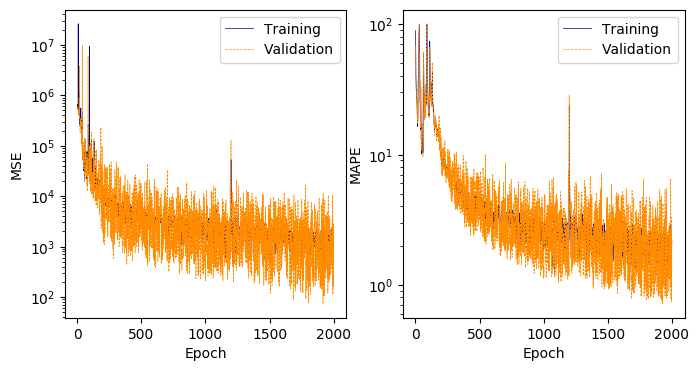

In [68]:
# Create a figure and 2 subplots.
fig, ax = plt.subplots(
    num = 'Learning',
    figsize = (8.0, 4.0),
    nrows = 1,
    ncols = 2
)

# Plot loss on the training data on the left subplot.
ax[0].plot(
    history.index + 1,
    history.loss,
    color = 'navy',
    linestyle = '-',
    linewidth = '0.5',
    marker = 'None',
    label = 'Training'
)

# Plot loss on the validation data on the right subplot.
ax[0].plot(
    history.index + 1,
    history.val_loss,
    color = 'darkorange',
    linestyle = '--',
    linewidth = '0.5',
    marker = 'None',
    label = 'Validation'
)

# Plot MAPE on the training data on the right subplot
ax[1].plot(
    history.index + 1,
    history.mean_absolute_percentage_error,
    color = 'navy',
    linestyle = '-',
    linewidth = '0.5',
    marker = 'None',
    label = 'Training'
)

# Plot MAPE on the validation data on the right subplot.
ax[1].plot(
    history.index + 1,
    history.val_mean_absolute_percentage_error,
    color = 'darkorange',
    linestyle = '--',
    linewidth = '0.5',
    marker = 'None',
    label = 'Validation'
)

# Set the y-axis scale to logarithmic on both subplots.
for i in six.moves.range(2):
    ax[i].set_yscale('log')
try:
    del i
except (NameError, UnboundLocalError):
    pass

# Set axis labels on the left subplot.
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('MSE')

# Set axis labels on the right subplot.
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('MAPE')

# Set legends on the subplots.
for i in six.moves.range(2):
    ax[i].legend(loc = 'upper right')
try:
    del i
except (NameError, UnboundLocalError):
    pass

# Save the figure
fig.savefig('neural_network_learning.pdf', bbox_inches = 'tight')

# Show the plots.
plt.show()


In [0]:
# Free the memory.
del fig
del ax


**Računanje greške na testnom skupu podataka&hellip;**


(greška je prikazana kao lista `[MSE, MAE, MAPE]`)


Na cijelom skupu&hellip;


In [70]:
model.evaluate(x = num.test[features_index], y = num.test.l_0, verbose = 0)


[78.13560050307173, 2.7251277433323016, 0.7924899312828279]

Po $ 5 \, \% $-tnim kvantilima&hellip;


In [71]:
# Display errors on 5 % quantiles.
for i in six.moves.range(int(l_0_quant.size) - 1):
    # Extract the indices of the `i`-th quantile.
    I = (num.test.l_0 >= l_0_quant[i]) & (num.test.l_0 < l_0_quant[i + 1])

    # Display the error on the `i`-th quantile.
    print(
        "{ind:2d}: {low:7.2f} -- {high:7.2f}".format(
            ind = i + 1,
            low = l_0_quant[i],
            high = l_0_quant[i + 1]
        )
    )
    display(
        model.evaluate(
            x = num.test.loc[I, features_index],
            y = num.test.loc[I, 'l_0'],
            verbose = 0
        )
    )
    print(str())

    # Free the memory.
    del I
try:
    del i
except (NameError, UnboundLocalError):
    pass


 1:   52.72 --   55.41


[6.408552696538526, 2.471376585405926, 4.550541928815433]


 2:   55.41 --   58.46


[0.6749512648535949, 0.6572076897689733, 1.1655673325572486]


 3:   58.46 --   62.06


[0.16948399401863756, 0.38027508168354757, 0.6309265590647881]


 4:   62.06 --   66.20


[0.33985431711423136, 0.4931756560137835, 0.7756953634130181]


 5:   66.20 --   71.01


[0.09960827749391227, 0.2659956563350766, 0.38653832382204484]


 6:   71.01 --   76.74


[0.045303875929248526, 0.1793753483778406, 0.24261595719155366]


 7:   76.74 --   83.51


[0.08861148984808671, 0.23694157717131634, 0.2977878700490389]


 8:   83.51 --   91.80


[0.15475800487519478, 0.3093763837907714, 0.3504217286004868]


 9:   91.80 --  102.00


[0.6231182517080295, 0.6439940914821741, 0.6652974554929184]


10:  102.00 --  114.76


[0.5227953808398113, 0.5606666209502202, 0.5203474312108762]


11:  114.76 --  130.69


[0.37748161830108345, 0.4792987910011553, 0.39087891502071037]


12:  130.69 --  152.54


[1.2238586885692733, 0.8911768939241201, 0.6336089194623464]


13:  152.54 --  181.99


[1.7110596289687232, 1.007123780221367, 0.6061825685868795]


14:  181.99 --  221.86


[2.382863773418319, 1.1145226271091213, 0.5511412968542176]


15:  221.86 --  282.86


[2.1953845511451635, 1.1067257225878235, 0.44365158330562504]


16:  282.86 --  381.22


[10.193733361243034, 2.503500668699038, 0.7602794974714043]


17:  381.22 --  541.76


[12.928412652219961, 2.9797269127797907, 0.6582598109140244]


18:  541.76 --  861.51


[43.50112639617453, 4.955173076877104, 0.7336118955944859]


19:  861.51 -- 1714.84


[128.3316060956864, 8.290417735404455, 0.6745328900280022]


20: 1714.84 -- 5942.29


[1350.7394167877908, 24.976503939494364, 0.8119112537715543]

**Grafički prikaz točnosti predviđanja&hellip;**


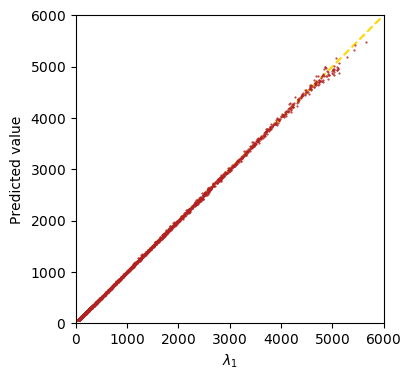

In [72]:
# Create a figure.
fig = plt.figure(num = 'Prediction error', figsize = (4.0, 4.0))

# Create a subplot.
ax = fig.add_subplot(1, 1, 1)

# Set the aspect of the subplot to equal.
ax.set_aspect('equal')

# Plot the identity line.
ax.plot(
    np.linspace(l_0_quant[0], l_0_quant[-1]),
    np.linspace(l_0_quant[0], l_0_quant[-1]),
    color = 'gold',
    linestyle = '--',
    marker = 'None'
)

# Plot lambda_0 prediction over true lambda_0.
try:
    ax.plot(
        num.test.l_0,
        K.get_value(
            model.predict(
                x = num.test[features_index],
                batch_size = 2048,
                verbose = 0
            )
        ),
        color = 'firebrick',
        linestyle = 'None',
        marker = '.',
        ms = 1
    )
except (AttributeError):
    ax.plot(
        num.test.l_0,
        model.predict(
            x = num.test[features_index],
            batch_size = 2048,
            verbose = 0
        ),
        color = 'firebrick',
        linestyle = 'None',
        marker = '.',
        ms = 1
    )

# Set axis labels.
ax.set_xlabel("$ \\lambda_{1} $")
ax.set_ylabel('Predicted value')

# Set ticks.
ax.set_xticks(ticks['l_0'])
ax.set_yticks(ticks['l_0'])

# Set tick labels.
ax.set_xticklabels(ticklabels['l_0'])
ax.set_yticklabels(ticklabels['l_0'])

# Set axis limits.
ax.set_xlim(lim['l_0'])
ax.set_ylim(lim['l_0'])

# Save the figure.
fig.savefig('neural_network_prediction.pdf', bbox_inches = 'tight')

# Show the plot.
plt.show()


In [0]:
# Free the memory.
del fig
del ax


### Zaključak <a class="anchor" id="nn-conclusion"></a>


Model neuronske mreže vrlo dobro predviđa najmanju svojstvenu vrijednost Laplaceovog operatora na trokutima. To znači da je poznavanje duljina stranica, veličina vanjskih kutova i singularnih vrijednosti duljina stranica i vanjskih kutova, na trokutima, dovoljno informacija da se relativno lako (aktivacijske funkcije su samo `ReLU` i multiplikativni inverz) izračuna tražena vrijednost. Kompleksnost ovakvog modela s porastom broja kutova raste linearno, no nije sigurno da bi ovakav model bio generalizabilan (za četverokute, peterokute&hellip;).


In [0]:
# Free the memory.
del num
del features_index
del model
del history


## Konvolucijska neuronska mreža <a class="anchor" id="convolutional-neural-network"></a>


Učitavanje podataka&hellip;


In [0]:
img = DataSet('imagination', DataSubSet.coordinates | DataSubSet.eigenvalues)


Konstruiranje indeksa stupaca s koordinatama vrhova&hellip;


In [0]:
coordinates = pd.Index(
    ['x_0', 'y_0', 'x_1', 'y_1', 'x_2', 'y_2'],
    dtype = str,
    copy = True
)


Konstruiranje *NumPy* polja s granicama vizualiziranog pravokutnika&hellip;


In [0]:
bbox = np.array(
    [[-1.0, -1.0], [1.0, 1.0]],
    dtype = float,
    copy = True,
    order = 'F',
    subok = False,
    ndmin = 2
)


Definiranje rezolucije vizualizacije&hellip;


In [0]:
res = 128


Konstruiranje vizualizacija trokuta i ekstrahiranje ciljne varijable&hellip;


In [0]:
# Initialise the family of sets of triangles' visualisations to an empty
# dictionary.
X = dict()

# Initialise the target value to an empty dictionary.
l_0 = dict()

# Construct the sets of triangles' visualisations for each of the datasets
# (trainig, validation and testing).
for name, df in zip(['train', 'validation', 'test'], iter(img)):
    # Initialise the set of visualisations to zeros.
    X.update(
        {
            name :
                np.zeros(
                    (int(df.shape[0]), res, res),
                    dtype = float,
                    order = 'C'
                )
        }
    )

    # Iterate over the triangles and visualise them.
    for i in six.moves.range(int(df.shape[0])):
        visualise_triangle(
            df.loc[i, coordinates],
            bbox = bbox,
            m = res + 1,
            n = res + 1,
            out = X[name][i]
        )

    # Normalise the visualisations so that the equilateral triangle's maximal
    # value reaches 1.
    X[name] *= (
        3.4641016151377545870548926830117447338856105076207612561116139589
    )

    # Copy the target values.
    l_0.update({name : df.l_0.values.copy(order = 'C')})
    try:
        del i
    except (NameError, UnboundLocalError):
        pass
try:
    del name
except (NameError, UnboundLocalError):
    pass
try:
    del df
except (NameError, UnboundLocalError):
    pass


In [0]:
# Free the memory.
del coordinates
del bbox


In [0]:
# Free the memory.
del img


In [82]:
# Free the memory.
gc.collect()


3820

**Konstruiranje modela neuronske mreže kao instance klase `keras.models.Sequential`&hellip;**


Arhitektura konvolucijske neuronske neuronske mreže inspirirana je modelom kojeg su razvili Mills, Spanner i Tamblyn u [[1]](#bib-Mills17), ali je zbog ograničenih resursa rezolucija ulaznih podataka reducirana na $ 128 \times 128 $, zbog čega je redukcijskih slojeva u neuronskoj mreži samo $ 6 $, a ne $ 7 $. Također, zbog manjka resursa mreža se trenira u samo $ 50 $ epoha pa će inicijalna brzina učenja u optimizaciji biti drugačija. Ostali hiperparametri (broj filtera, veličina jezgre i pomaka, aktivacijske funkcije&hellip;) isti su kao u originalnom modelu.


In [0]:
model = MST_CNN_sequential(input_shape = (res, res, 1), reductions = 6)
model.add(kl.Dense(units = 1, activation = 'linear', name = 'output'))


In [0]:
# Free the memory.
del res


In [85]:
# Free the memory.
gc.collect()


17

**Izgradnja neuronske mreže&hellip;**


(inicijalna brzina učenja postavljena je na $ 1.0 \cdot 10^{{- 2}} $, a ne na $ 1.0 \cdot 10^{{- 3}} $ kao u [[1]](#bib-Mills17))


In [0]:
model.compile(
    optimizer = MST_CNN_optimiser(lr = 1.0e-2),
    loss = 'mean_squared_error',
    metrics = ['mean_absolute_error', 'mean_absolute_percentage_error']
)


**Treniranje neuronske mreže&hellip;**


In [87]:
# Train the model.
history = model.fit(
    x = X['train'][:, :, :, np.newaxis],
    y = l_0['train'],
    batch_size = 256,
    epochs = 50,
    validation_data = (X['validation'][:, :, :, np.newaxis], l_0['validation']),
    shuffle = True,
    verbose = 1,
    callbacks = [
        kc.TerminateOnNaN(),
        kc.ModelCheckpoint(
            'models/convolutional_neural_network.h5',
            monitor = 'val_loss',
            save_best_only = True,
            mode = 'min',
            period = 1
        )
    ]
)

# Save the history as a CSV table.
pd.DataFrame(history.history).to_csv(
    'models/convolutional_neural_network_history.csv',
    sep = ',',
    float_format = "%.8f",
    header = True,
    index = True
)

# Delete the model and the history.
del model
del history

# Load the model with the best weights.
model = km.load_model('models/convolutional_neural_network.h5')

# Load the history.
history = pd.read_csv(
    'models/neural_network_history.csv',
    header = 0,
    index_col = 0
)


Train on 70000 samples, validate on 15000 samples
Epoch 1/50
70000/70000 [==============================] - 36s 510us/step - loss: 505914.7333 - mean_absolute_error: 343.0529 - mean_absolute_percentage_error: 139.9663 - val_loss: 309457.2141 - val_mean_absolute_error: 183.1562 - val_mean_absolute_percentage_error: 34.5845
Epoch 2/50
70000/70000 [==============================] - 32s 450us/step - loss: 124794.3149 - mean_absolute_error: 141.8261 - mean_absolute_percentage_error: 41.4498 - val_loss: 20993.4335 - val_mean_absolute_error: 51.7058 - val_mean_absolute_percentage_error: 15.6191
Epoch 3/50
70000/70000 [==============================] - 32s 450us/step - loss: 22815.9836 - mean_absolute_error: 57.3149 - mean_absolute_percentage_error: 17.2185 - val_loss: 7228.8594 - val_mean_absolute_error: 32.1757 - val_mean_absolute_percentage_error: 9.5160
Epoch 4/50
70000/70000 [==============================] - 32s 450us/step - loss: 6438.2741 - mean_absolute_error: 30.4572 - mean_absolute_

**Prikaz učenja neuronske mreže&hellip;**

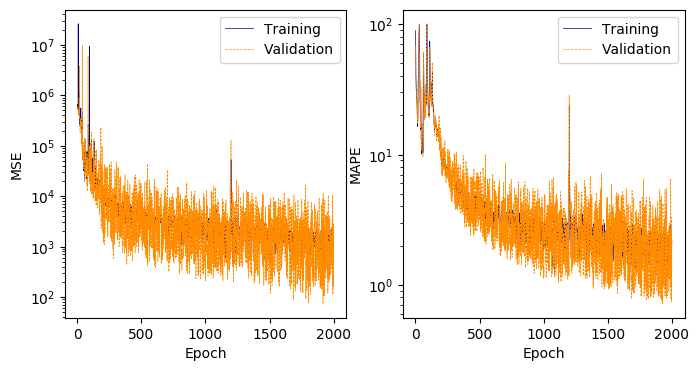

In [88]:
# Create a figure and 2 subplots.
fig, ax = plt.subplots(
    num = 'Learning',
    figsize = (8.0, 4.0),
    nrows = 1,
    ncols = 2
)

# Plot loss on the training data on the left subplot.
ax[0].plot(
    history.index + 1,
    history.loss,
    color = 'navy',
    linestyle = '-',
    linewidth = '0.5',
    marker = 'None',
    label = 'Training'
)

# Plot loss on the validation data on the right subplot.
ax[0].plot(
    history.index + 1,
    history.val_loss,
    color = 'darkorange',
    linestyle = '--',
    linewidth = '0.5',
    marker = 'None',
    label = 'Validation'
)

# Plot MAPE on the training data on the right subplot
ax[1].plot(
    history.index + 1,
    history.mean_absolute_percentage_error,
    color = 'navy',
    linestyle = '-',
    linewidth = '0.5',
    marker = 'None',
    label = 'Training'
)

# Plot MAPE on the validation data on the right subplot.
ax[1].plot(
    history.index + 1,
    history.val_mean_absolute_percentage_error,
    color = 'darkorange',
    linestyle = '--',
    linewidth = '0.5',
    marker = 'None',
    label = 'Validation'
)

# Set the y-axis scale to logarithmic on both subplots.
for i in six.moves.range(2):
    ax[i].set_yscale('log')
try:
    del i
except (NameError, UnboundLocalError):
    pass

# Set axis labels on the left subplot.
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('MSE')

# Set axis labels on the right subplot.
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('MAPE')

# Set legends on the subplots.
for i in six.moves.range(2):
    ax[i].legend(loc = 'upper right')
try:
    del i
except (NameError, UnboundLocalError):
    pass

# Save the figure
fig.savefig('convolutional_neural_network_learning.pdf', bbox_inches = 'tight')

# Show the plots.
plt.show()


In [0]:
# Free the memory.
del fig
del ax


**Računanje greške na testnom skupu podataka&hellip;**


(greška je prikazana kao lista `[MSE, MAE, MAPE]`)


Na cijelom skupu&hellip;


In [90]:
model.evaluate(x = X['test'][:, :, :, np.newaxis], y = l_0['test'], verbose = 0)


[479.6158914876302, 10.443328466796874, 6.894954950714111]

Po $ 5 \, \% $-tnim kvantilima&hellip;


In [91]:
# Display errors on 5 % quantiles.
for i in six.moves.range(int(l_0_quant.size) - 1):
    # Extract the indices of the `i`-th quantile.
    I = (l_0['test'] >= l_0_quant[i]) & (l_0['test'] < l_0_quant[i + 1])

    # Display the error on the `i`-th quantile.
    print(
        "{ind:2d}: {low:7.2f} -- {high:7.2f}".format(
            ind = i + 1,
            low = l_0_quant[i],
            high = l_0_quant[i + 1]
        )
    )
    display(
        model.evaluate(
            x = X['test'][I, :, :, np.newaxis],
            y = l_0['test'][I],
            verbose = 0
        )
    )
    print(str())

    # Free the memory.
    del I
try:
    del i
except (NameError, UnboundLocalError):
    pass


 1:   52.72 --   55.41


[96.01745155843099, 9.73239340464274, 17.87330983988444]


 2:   55.41 --   58.46


[80.28114693196615, 8.827702107747395, 15.479659873962403]


 3:   58.46 --   62.06


[70.29987800089518, 8.187139649709065, 13.570606953938801]


 4:   62.06 --   66.20


[68.33585055541992, 8.06663506189982, 12.56879793548584]


 5:   66.20 --   71.01


[70.52419361368815, 8.15518250656128, 11.900298914591472]


 6:   71.01 --   76.74


[69.6963940633138, 8.034541748046875, 10.872580533345541]


 7:   76.74 --   83.51


[62.6252319132487, 7.537943188985189, 9.42148545328776]


 8:   83.51 --   91.80


[58.62883917236328, 7.195056630452474, 8.216208230336507]


 9:   91.80 --  102.00


[52.83305514526367, 6.812059065500895, 7.05063595199585]


10:  102.00 --  114.76


[49.205853759765624, 6.59253130086263, 6.0970694287618]


11:  114.76 --  130.69


[42.82543732706706, 5.9649231948852535, 4.882151238759358]


12:  130.69 --  152.54


[46.34615662638346, 5.981306988398234, 4.246239414215088]


13:  152.54 --  181.99


[34.64034498087565, 5.123857339223226, 3.089693562825521]


14:  181.99 --  221.86


[40.416240234375, 5.412479780832927, 2.704610246658325]


15:  221.86 --  282.86


[32.99304905192057, 4.763525918324788, 1.9136526292165121]


16:  282.86 --  381.22


[43.247018575032556, 5.218697959899902, 1.5890018173853557]


17:  381.22 --  541.76


[76.66900931803386, 6.918642781575521, 1.5258350009918213]


18:  541.76 --  861.51


[145.7282909342448, 9.723519526163736, 1.4311983420054117]


19:  861.51 -- 1714.84


[516.1129518229167, 17.56244921875, 1.446303612391154]


20: 1714.84 -- 5942.29


[7934.890010416667, 63.055965677897134, 2.019752066294352]

**Grafički prikaz točnosti predviđanja&hellip;**


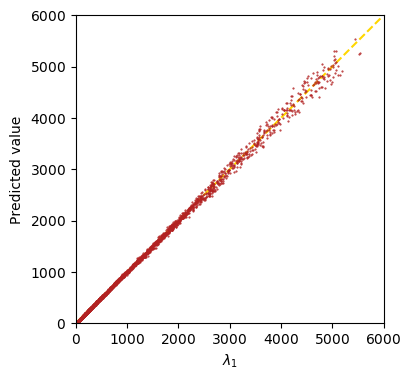

In [92]:
# Create a figure.
fig = plt.figure(num = 'Prediction error', figsize = (4.0, 4.0))

# Create a subplot.
ax = fig.add_subplot(1, 1, 1)

# Set the aspect of the subplot to equal.
ax.set_aspect('equal')

# Plot the identity line.
ax.plot(
    np.linspace(l_0_quant[0], l_0_quant[-1]),
    np.linspace(l_0_quant[0], l_0_quant[-1]),
    color = 'gold',
    linestyle = '--',
    marker = 'None'
)

# Plot lambda_0 prediction over true lambda_0.
try:
    ax.plot(
        l_0['test'],
        K.get_value(
            model.predict(
                x = X['test'][:, :, :, np.newaxis],
                batch_size = 2048,
                verbose = 0
            )
        ),
        color = 'firebrick',
        linestyle = 'None',
        marker = '.',
        ms = 1
    )
except (AttributeError):
    ax.plot(
        l_0['test'],
        model.predict(
            x = X['test'][:, :, :, np.newaxis],
            batch_size = 2048,
            verbose = 0
        ),
        color = 'firebrick',
        linestyle = 'None',
        marker = '.',
        ms = 1
    )

# Set axis labels.
ax.set_xlabel("$ \\lambda_{1} $")
ax.set_ylabel('Predicted value')

# Set ticks.
ax.set_xticks(ticks['l_0'])
ax.set_yticks(ticks['l_0'])

# Set tick labels.
ax.set_xticklabels(ticklabels['l_0'])
ax.set_yticklabels(ticklabels['l_0'])

# Set axis limits.
ax.set_xlim(lim['l_0'])
ax.set_ylim(lim['l_0'])

# Save the figure.
fig.savefig(
    'convolutional_neural_network_prediction.pdf',
    bbox_inches = 'tight'
)

# Show the plot.
plt.show()


In [0]:
# Free the memory.
del fig
del ax


### Zaključak <a class="anchor" id="cnn-conclusion"></a>


Konvolucijska neuronska mreža također dobro predviđa najmanju svojstvenu vrijednost Laplaceovog operatora na trokutima. Najveća prednost koju ovaj model ima nad ranije promatranima je njegova generalizabilnost&mdash;za proučavanje mnogokutova s više kutova (četverokuti, peterokuti&hellip;) ne raste nužno kompleksnost modela, kao što se pojavljuje više koordinata karakterističnih točaka za polinome ili više numeričkih vrijednosti za obične neuronske mreže. Međutim, za $ n $-terokute za veliki $ n \in \mathbb{N} $ možda rezolucija $ 128 \times 128 $ na pravokutniku $ \left[ {- 1} , 1 \right] \times \left[ {- 1} , 1 \right] $ nije dovoljna pa bi se kompleksnost modela tada možda ipak trebala povećati.

Također, generalizirani model konvolucijske neuronske mreže, ako bi bio dobar, mogao bi istovremeno predviđati najmanju svojstvenu vrijednost na svim $ n $-terokutovima za $ n \in \left\{ 3 , 4 , \dotsc , m \right\} $ za neki $ m \in \mathbb{N} $, $ m \geq 3 $. Kod prethodno promatranih modela za takvu generalizaciju potrebne su konvencije o postavljanju nepravih vrhova na stranice (na primjer, na najdulju stranicu umetnemo kao novi vrh njezino polovište; postupak ponavljamo dok broj vrhova nije dovoljan) ili povećani skup podataka (s više izbora o umetanju nepravih vrhova).


In [0]:
# Free the memory.
del X
del l_0
del model
del history


## Literatura <a class="anchor" id="bibliography"></a>


1.   K. Mills, M. Spanner, I. Tamblyn, *Deep Learning and the Schr&ouml;dinger Equation*, 2017, arXiv: [`1702.01361 [cond-mat.mtrl-sci]`](https://arxiv.org/abs/1702.01361). <a class="anchor" id="bib-Mills17"></a>


In [95]:
# Free the memory.
gc.collect()


22047